In [ ]:
# author: Jana Lasser

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import krippendorff
import pingouin as pt
from scipy.stats import pearsonr

In [2]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"

/home/jana/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# New York Times corpus

**Note**: the below code won't work if you haven't collected the NYT articles corpus yourself, since we can't share the data.

In [25]:
src = "../../data/NYT/"
# get honesty scores
fname = "NYT_abstracts_honesty_component_scores_glove.csv.gzip"
honesty_scores = pd.read_csv(Path(src, fname), compression="gzip")

fname = "NYT_abstracts.csv.gzip"
# get abstract categories
cols = ["id", "section"]
abstracts = pd.read_csv(Path(src, fname), compression="gzip", usecols=cols)

abstracts = pd.merge(
    abstracts,
    honesty_scores,
    how="left",
    left_on="id",
    right_on="id"
)

# merge categories
abstracts["section"] = abstracts["section"].replace({
    "Climate":"Science",
    "Education":"Science",
    "Health":"Science",
    "U.S.":"Politics",
    "Washington":"Politics",
    "World":"Politics"
})
abstracts.head(3)

,id,section,avg_truth_score,avg_belief_score
0,4fd10a478eb7c8105d5bdb80,Politics,0.421069,0.502379
1,4fd10f2a8eb7c8105d5c4039,Politics,0.563957,0.516552
2,4fd10f2a8eb7c8105d5c407e,Opinion,0.618621,0.742473


In [26]:
# calculate corpus means for belief-speaking and truth-seeking similarity
belief_corpus_mean = abstracts["avg_belief_score"].mean()
truth_corpus_mean = abstracts["avg_truth_score"].mean()

In [27]:
abstracts[["section", "avg_belief_score"]].groupby("section").mean() - belief_corpus_mean

,avg_belief_score
section,
Opinion,0.014221
Politics,-0.007335
Science,0.007502


In [28]:
abstracts[["section", "avg_truth_score"]].groupby("section").mean() - truth_corpus_mean

,avg_truth_score
section,
Opinion,0.005548
Politics,-0.007357
Science,0.048976


In [29]:
del honesty_scores
del abstracts

# Users

In [30]:
src = "../../data/users"
fname = "US_politician_accounts_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(Path(src, fname), dtype={"author_id":str})
users.head(3)

,handle,author_id,name,party,N_tweets,followers_count,following_count,tweet_count,created_at,congress,...,avg_truth_score_2019_to_2022,LIWC_analytic_mean,LIWC_authentic_mean,LIWC_emo_pos_mean,LIWC_emo_neg_mean,LIWC_moral_mean,ideology_mean,ideology_std,ideology_count,pf_score
0,RepLipinski,1009269193,Former Rep. Daniel Lipinski,Democrat,3179,19893.0,2478.0,4359.0,2012-12-13 17:03:06+00:00,116.0,...,0.563447,82.752486,39.963044,1.228396,0.274875,0.598755,0.471657,0.055874,8.0,NaN
1,CaptClayHiggins,1011053278304592000,Clay Higgins,Republican,21,3289.0,156.0,24.0,2018-06-25 01:07:40+00:00,116.0,...,0.450737,55.855385,30.375385,0.788462,2.152308,3.519231,0.282969,0.041444,8.0,NaN
2,SenBillCassidy,1017500185356852992,"U.S. Senator Bill Cassidy, M.D.",Republican,3691,49027.0,1420.0,5979.0,2018-07-12 20:05:23+00:00,116.0,...,0.557309,72.967450,37.168018,0.897189,0.411022,0.638981,0.797008,0.038197,8.0,0.05


In [35]:
dem = users[users["party"] == "Democrat"].copy()
rep = users[users["party"] == "Republican"].copy()

## Number of Democrats and Republicans in both time periods

In [36]:
len(dem["avg_belief_score_2010_to_2013"].dropna())

128

In [37]:
len(dem["avg_belief_score_2019_to_2022"].dropna())

515

In [38]:
len(rep["avg_belief_score_2010_to_2013"].dropna())

166

In [39]:
len(rep["avg_belief_score_2019_to_2022"].dropna())

469

## Mean values of belief-speaking and truth-seeking similarity

In [40]:
dem["avg_belief_score_2010_to_2013"].mean()

0.45141602245774337

In [41]:
dem["avg_belief_score_2019_to_2022"].mean()

0.5994718415031841

In [42]:
rep["avg_belief_score_2010_to_2013"].mean()

0.44126319259356717

In [43]:
rep["avg_belief_score_2019_to_2022"].mean()

0.5828170773628023

In [44]:
dem["avg_truth_score_2010_to_2013"].mean()

0.3963573963208399

In [45]:
dem["avg_truth_score_2019_to_2022"].mean()

0.5498971020328406

In [46]:
rep["avg_truth_score_2010_to_2013"].mean()

0.3865088406629971

In [47]:
rep["avg_truth_score_2019_to_2022"].mean()

0.5247807354848475

## T-tests to compare differences

In [48]:
# Democrats belief-speaking
pt.ttest(dem["avg_belief_score_2010_to_2013"],
         dem["avg_belief_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-27.568351,176.412474,two-sided,7.554521e-66,"[-0.16, -0.14]",2.982276,7.182e+106,1.0


In [49]:
# Republicans belief-speaking
pt.ttest(rep["avg_belief_score_2010_to_2013"],
         rep["avg_belief_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-23.455095,226.413581,two-sided,1.591857e-62,"[-0.15, -0.13]",2.484678,1.316e+84,1.0


In [50]:
# Democrats truth-seeking
pt.ttest(dem["avg_truth_score_2010_to_2013"],
         dem["avg_truth_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-29.347828,174.276108,two-sided,2.401095e-69,"[-0.16, -0.14]",3.214738,3.431e+116,1.0


In [51]:
# Republicans truth-seeking
pt.ttest(rep["avg_truth_score_2010_to_2013"],
         rep["avg_truth_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-25.103991,237.786923,two-sided,8.410439e-69,"[-0.15, -0.13]",2.56367,1.205e+93,1.0


# Tweets

## Number of tweets

In [79]:
src = "../../data/tweets"
fname = "US_politician_tweets_2010-11-06_to_2022-03-16.csv.gzip"
tweets = pd.read_csv(Path(src, fname), compression="gzip", parse_dates=["created_at"])

In [80]:
print(f"number of tweets in the corpus: {len(tweets)}")
print("number of original in the corpus: {}"\
      .format(len(tweets[(tweets["retweeted"] == False) &\
                         (tweets["quoted"] == False) &\
                         (tweets["reply"] == False)])))
print("number of quoted tweets in the corpus: {}"\
      .format(len(tweets[tweets["quoted"] == True])))
print("number of replies in the corpus: {}"\
      .format(len(tweets[tweets["reply"] == True])))
print("number of retweets in the corpus: {}"\
      .format(len(tweets[tweets["retweeted"] == True])))

number of tweets in the corpus: 2588559
number of original in the corpus: 1523050
number of quoted tweets in the corpus: 266737
number of replies in the corpus: 248511
number of retweets in the corpus: 552892


In [81]:
# drop retweets
N = len(tweets)
tweets = tweets[tweets["retweeted"] == False]
print(f"dropped {N - len(tweets)} retweets")

dropped 552892 retweets


In [82]:
len(tweets)

2035667

In [83]:
len(tweets["author_id"].unique())

1034

In [84]:
tweets["year"] = pd.to_datetime(tweets["created_at"]).dt.year

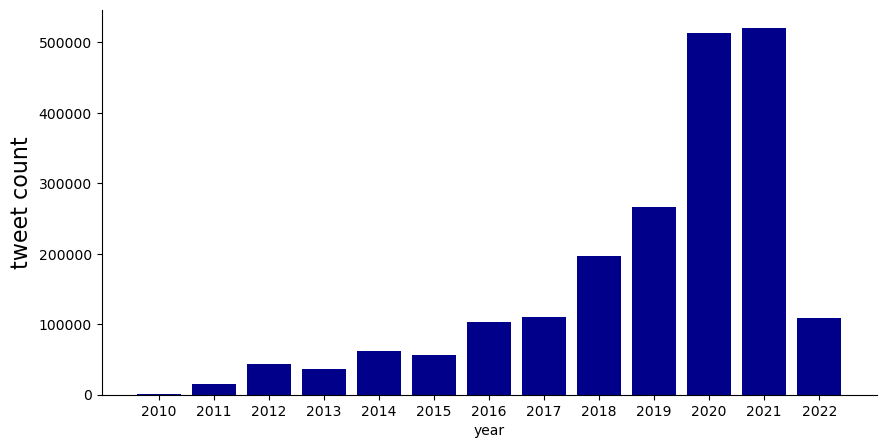

In [85]:
counts, years = np.histogram(tweets["year"], bins=range(2010, 2022))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(tweets["year"].value_counts(ascending=True).index,
       tweets["year"].value_counts(ascending=True).values,
       color="DarkBlue")
ax.set_xticks(range(2010, 2023))
ax.set_ylabel("tweet count", fontsize=16)
ax.set_xlabel("year", fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [86]:
# drop tweets without honesty component (distill RoBERTa filtering)
N = len(tweets)
tweets = tweets.dropna(subset=["avg_belief_score", "avg_truth_score"])
print(f"dropped {N - len(tweets)} tweets without an honesty score")

dropped 228822 tweets without an honesty score


In [87]:
# set tweet creation date as index for easier sampling and aggregation
tweets = tweets.set_index("created_at")

In [88]:
# drop tweets from 2010
N = len(tweets)
tweets = tweets[tweets.index.year > 2010]
print(f"dropped {N - len(tweets)} tweets from before 2011")

dropped 772 tweets from before 2011


In [89]:
print(f"N tweets in final corpus {len(tweets)}")

N tweets in final corpus 1806073


In [90]:
tweets["has_url"].sum()

1328411

## Score correlations

In [64]:
tweets["avg_belief_score"].mean()

0.5719579937734619

In [65]:
tweets["avg_truth_score"].mean()

0.5254136428785026

In [66]:
pearsonr(tweets["avg_belief_score"], tweets["LIWC_analytic"])

(-0.23414270490361974, 0.0)

In [67]:
pearsonr(tweets["avg_truth_score"], tweets["LIWC_analytic"])

(-0.11909292286549945, 0.0)

In [68]:
pearsonr(tweets["avg_belief_score"], tweets["LIWC_authentic"])

(0.08879377069881633, 0.0)

In [69]:
pearsonr(tweets["avg_truth_score"], tweets["LIWC_authentic"])

(0.03893889750332938, 0.0)

In [70]:
pearsonr(tweets["avg_belief_score"], tweets["LIWC_moral"])

(0.0700075655166808, 0.0)

In [71]:
pearsonr(tweets["avg_truth_score"], tweets["LIWC_moral"])

(0.008842714807681814, 1.4339591049852488e-32)

In [72]:
pearsonr(tweets["avg_belief_score"], tweets["LIWC_emo_pos"])

(-0.06523965238331189, 0.0)

In [73]:
pearsonr(tweets["avg_truth_score"], tweets["LIWC_emo_pos"])

(-0.18635375756795872, 0.0)

In [74]:
pearsonr(tweets["avg_belief_score"], tweets["LIWC_emo_neg"])

(0.11486025646177159, 0.0)

In [75]:
pearsonr(tweets["avg_truth_score"], tweets["LIWC_emo_neg"])

(0.04349723801335499, 0.0)

# URLs

In [91]:
src = "../../data/urls"
fname = "US_politician_URLs_2010-11-06_to_2022-03-16.csv.gzip"
urls = pd.read_csv(join(src, fname), compression="gzip", parse_dates=["created_at"])

In [92]:
len(urls[urls["id"].isin(tweets["id"])])

1425813

In [93]:
del urls
del tweets

# Articles

In [98]:
src = "../../data/articles"
fname = "article_corpus_clean.csv.gzip"
articles = pd.read_csv(Path(src, fname), compression="gzip")
len(articles)

153914

In [99]:
del articles

# Trustworthiness scores

## NewsGuard nutrition scores

In [100]:
# load the nutrition labels
src = "../../data/utilities"
fname = "NewsGuard_labels.csv"
NG_scores = pd.read_csv(join(src, fname))
# if more than one score exists for the same domain, keep the most recent one
NG_scores = NG_scores.sort_values(by=["Domain","Last Updated"], ascending=False)
NG_scores = NG_scores.drop_duplicates(subset=["Domain"])

# threshold scores at various cutoffs to define untrustworthy domains
NG_scores["NewsGuard_unreliable"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "NewsGuard_unreliable"] = 1
unreliable_60_domains = set(NG_scores[NG_scores["NewsGuard_unreliable"] == 1]["Domain"])

In [101]:
number_of_english_domains = NG_scores["Language"].value_counts().loc["en"]

unreliable_60 = len(NG_scores[(NG_scores["Language"] == "en") &\
                        (NG_scores["Score"] < 60)]) / \
                        len(NG_scores[NG_scores["Language"] == "en"])

print("The NewsGuard dataset as of 2022-03-01 contains {} english entries"\
        .format(number_of_english_domains))
print("{:1.2f} % ({}) of English entries have a score < 60"\
        .format(unreliable_60 * 100, len(unreliable_60_domains)))

The NewsGuard dataset as of 2022-03-01 contains 6860 english entries
37.24 % (2757) of English entries have a score < 60


Text(15, 2000, 'not trustworthy')

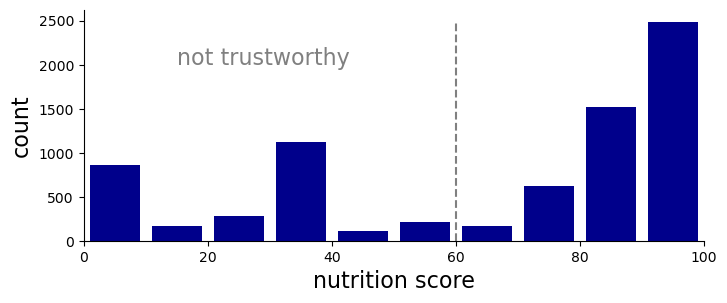

In [102]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(NG_scores["Score"], rwidth=0.8, color="DarkBlue")
ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("count", fontsize=16)
ax.set_xlabel("nutrition score", fontsize=16)
ax.plot([60, 60], [0, 2500], '--', color="grey")
ax.text(15, 2000, "not trustworthy", color="grey", fontsize=16)

## Independent trustworthiness labels

In [103]:
# load the list of independently compiled trustworthiness labels for 
# news sources
src = "../../data/utilities"
fname = "independent_labels.csv"
alt_labels = pd.read_csv(join(src, fname))
alt_labels = alt_labels.rename(columns = {"type":"unreliable", "url":"Domain"})

# convert reliability labels to binary
alt_labels["unreliable"] = alt_labels["unreliable"]\
    .replace({"reliable":0, "unreliable":1})
N_alt_labels = len(alt_labels)
N_alt_untrustworthy = alt_labels["unreliable"].value_counts().loc[1]

In [107]:
NG_domains = set(NG_scores["Domain"])
alt_domains = set(alt_labels["Domain"])
shared_domains = len(NG_domains.intersection(alt_domains))
untrustworthy_domains = set(alt_labels[alt_labels["unreliable"] == 1]["Domain"])
shared_untrustworthy_domains_60 = len(unreliable_60_domains\
                                   .intersection(untrustworthy_domains))

In [108]:
print(f"The alternative list contains {N_alt_labels} domains")
print(f"Out of which {N_alt_untrustworthy} are labelled 'untrustworthy'")
print(f"{shared_domains} domains are also indexed by NewsGuard")
print(f"{shared_untrustworthy_domains_60} untrustworthy domains are also indexed by NewsGuard (score < 60)")

The alternative list contains 4767 domains
Out of which 2170 are labelled 'untrustworthy'
1677 domains are also indexed by NewsGuard
566 untrustworthy domains are also indexed by NewsGuard (score < 60)


## Comparison NewsGuard <-> independent labels

In [109]:
alt_domains = set(alt_labels["Domain"])

In [110]:
len(alt_domains)

4767

In [111]:
alt_labels["unreliable"].value_counts()

0    2597
1    2170
Name: unreliable, dtype: int64

In [112]:
NG_domains = set(NG_scores["Domain"])

In [113]:
in_both = alt_domains.intersection(NG_domains)
len(in_both)

1677

In [114]:
alt_labels[alt_labels["Domain"].isin(list(NG_domains))]["unreliable"].value_counts()

0    1062
1     615
Name: unreliable, dtype: int64

In [115]:
alt_labels["unreliable"] = alt_labels["unreliable"].replace({
    "reliable":0,
    "unreliable":1
})

In [116]:
NG_scores["unreliable"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "unreliable"] = 1

In [117]:
labels_NG = NG_scores[NG_scores["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
labels_ind = alt_labels[alt_labels["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
joint_labels = pd.DataFrame({
    "label_NG":labels_NG["unreliable"].values,
    "label_ind":labels_ind["unreliable"].values})

same = len(joint_labels[joint_labels["label_NG"] == joint_labels["label_ind"]])
kripp = krippendorff.alpha(joint_labels.transpose())
print(f"number of same labels: {same}, krippendorff's alpha: {kripp}")

number of same labels: 1553, krippendorff's alpha: 0.8422170341180256
